In [790]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import Ridge
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [791]:
def loadData (flow, meta):
    df1 = pd.read_csv(f'{flow}', delim_whitespace=True, header=None)
    df1.columns = ['ID', 'Year', 'Mnth', 'Day', 'Flow0', 'SYM']
    df1['datetime'] = pd.to_datetime(df1[['Year', 'Mnth', 'Day']].rename(columns={'Year': 'year', 'Mnth': 'month', 'Day': 'day'}))
    df1.drop(['ID', 'Year', 'Mnth', 'Day'], axis=1, inplace=True)
    df2 = pd.read_csv(f'{meta}', skiprows=3, delim_whitespace=True)
    df = pd.concat([df1, df2], axis=1)
    df = pd.get_dummies(df, columns=['SYM'], dummy_na=True)
    df.set_index('datetime', inplace=True)
    df.drop(['Hr'], axis=1, inplace=True)
    before = 3
    after = 3
    # for i in range(1, before + 1):
    #     df[f'Flow-{i}'] = df['Flow0'].shift(+i)  # Shift down by 1   
    for i in  range(1, after + 1):
        df[f'Flow+{i}'] = df['Flow0'].shift(-i)  # Shift up by 1   
    df = df.dropna()
    return df


In [792]:
df = loadData('Data/Idaho/13340000_streamflow_qc.txt', 'Data/Idaho/13340000_lump_maurer_forcing_leap.txt')


C:\Users\Abdullah Usmani\AppData\Local\Temp\ipykernel_11068\2899373820.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df1 = pd.read_csv(f'{flow}', delim_whitespace=True, header=None)
C:\Users\Abdullah Usmani\AppData\Local\Temp\ipykernel_11068\2899373820.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df2 = pd.read_csv(f'{meta}', skiprows=3, delim_whitespace=True)


In [793]:
def expand_mean(df):
    return df.expanding(1).mean()
def pct_diff(old, new):
    return (new-old) / old
def compute_rolling(df, horizon, col):
    label = f"rolling_{horizon}_{col}"

    df[label] = df[col].rolling(horizon).mean()
    df[f"{label}_pct"] = pct_diff(df[label], df[col])
    return df

rolling_horizons = [3, 7, 14]

for horizon in rolling_horizons:
    for col in ['prcp(mm/day)', 'srad(W/m2)', 'Flow0', 'tmax(C)', 'tmin(C)', 'vp(Pa)']:
        df = compute_rolling(df, horizon, col)

df = df.fillna(0)

for col in ['prcp(mm/day)', 'srad(W/m2)', 'tmax(C)', 'Flow0', 'tmin(C)', 'vp(Pa)']:
    df[f'month_avg_{col}'] = df[col].groupby(df.index.month, group_keys=False).apply(expand_mean)
    df[f'day_avg_{col}'] = df[col].groupby(df.index.day_of_year, group_keys=False).apply(expand_mean)

In [815]:
def visualization (y_pred, y_test, zoom_start, zoom_end):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    accuracy = 100 - np.mean(mape)
    r2 = r2_score(y_test, y_pred)
    
    print(f"MAE: {round(mae, 2)} m3/s")
    print(f"MSE: {round(mse, 2)} m3/s")
    print(f"RMSE: {round(np.sqrt(mse), 2)} m3/s")
    print(f"MAPE: {round(mape, 2)}%")
    print(f"Accuracy: {round(accuracy, 3)}%")
    print(f"R2: {round(r2, 4)}")
    plt.figure(figsize=(14, 8))
    # # Plot Actual vs Predicted for each Flow
    # for i in range(y_pred.shape[0]):
    #     plt.plot(range(len(y_test)), y_test[:, i], label=f'Actual Flow+{i}', color='black')
    #     plt.plot(range(len(y_pred)), y_pred[:, i], label=f'Predicted Flow+{i}', color=f'C{i}')

    plt.plot(range(len(y_test)), y_test, label=f'Actual Flow', color='black')
    plt.plot(range(len(y_pred)), y_pred, label=f'Predicted Flow', linestyle='--', color=f'C0')

    plt.xlabel('Index')
    plt.ylabel('Streamflow (m3/s)')
    plt.title('Actual vs Predicted Streamflow Values')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(14, 8))

    # Plot Actual vs Predicted for Flow
    plt.plot(range(len(y_test)), y_test, label='Actual Flow', color='black')
    plt.plot(range(len(y_pred)), y_pred, label='Predicted Flow', color='C0')

    plt.xlabel('Index')
    plt.ylabel('Streamflow (m3/s)')
    plt.title('Actual vs Predicted Streamflow Values')

    # Set the x and y limits to zoom in
    plt.xlim(zoom_start, zoom_end)
    plt.ylim(min(y_test[zoom_start:zoom_end].min(), y_pred[zoom_start:zoom_end].min()), 
            max(y_test[zoom_start:zoom_end].max(), y_pred[zoom_start:zoom_end].max()))

    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(14, 8))
    residuals = y_test - y_pred
    plt.plot(range(len(residuals)), residuals, label=f'Residuals Flow+{i}')
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel('Index')
    plt.ylabel('Residual (m3/s)')
    plt.title('Residuals for Each Day Ahead Prediction')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(14, 8))
    plt.scatter(y_pred, residuals, alpha=0.5, label=f'Residuals for Flow+{i}')
    # Plot a horizontal line at zero to show where residuals should ideally be
    plt.axhline(0, color='black', linestyle='--', label='Zero Residual Line')
    plt.xlabel('Predicted Streamflow (m3/s)')
    plt.ylabel('Residual (m3/s)')
    plt.title('Residual Scatter Plot for Each Day Ahead Prediction')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(14, 8))
    plt.scatter(y_test, y_pred, label=f'Flow+{i}', alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', linestyle='--', label='Ideal Fit')
    plt.xlabel('Actual Streamflow (m3/s)')
    plt.ylabel('Predicted Streamflow (m3/s)')
    plt.title('Actual vs Predicted Streamflow Scatter Plot')
    plt.legend()
    plt.grid(True)
    plt.show()
    

In [795]:
def permutation_importance(model, X_test, y_test, metric=mean_squared_error):
    baseline_score = metric(y_test, model.predict(X_test))
    importances = []
    
    for i in range(X_test.shape[1]):
        X_test_permuted = X_test.copy()
        np.random.shuffle(X_test_permuted[:, i])
        permuted_score = metric(y_test, model.predict(X_test_permuted))
        importances.append(permuted_score - baseline_score)
    
    return np.array(importances)

In [796]:
features_to_drop = [
    'Year', 'SYM_A', 'SYM_A:e', 'rolling_3_prcp(mm/day)', 'rolling_3_srad(W/m2)_pct',
    'rolling_3_tmax(C)_pct', 'rolling_3_tmin(C)_pct', 'rolling_7_prcp(mm/day)',
    'rolling_7_prcp(mm/day)_pct', 'rolling_7_tmax(C)', 'rolling_7_tmax(C)_pct',
    'rolling_7_tmin(C)_pct', 'rolling_7_vp(Pa)', 'rolling_14_srad(W/m2)_pct',
    'rolling_14_tmax(C)', 'rolling_14_tmin(C)', 'month_avg_vp(Pa)', 'day_avg_vp(Pa)',
    'Mnth', 'Day', 'rolling_14_prcp(mm/day)', 'month_avg_tmax(C)', 'swe(mm)', 'SYM_nan', 'tmax(C)', 'tmin(C)', 
    'rolling_3_tmax(C)', 'rolling_14_srad(W/m2)', 
    'rolling_14_tmax(C)_pct', 'rolling_14_tmin(C)_pct', 
    'month_avg_prcp(mm/day)', 'month_avg_srad(W/m2)'
]

# Drop the features from the DataFrame
df = df.drop(columns=features_to_drop)


In [797]:

Y = df['Flow+3']  # Target variable
adjX = df.drop(['Flow0', 'Flow+1', 'Flow+2', 'Flow+3'], axis=1)  # Features
X = adjX.columns

In [798]:

model = keras.Sequential([
            Dense(64, activation='relu', input_shape=(X.shape[0],), kernel_regularizer='l2'),
            Dropout(0.2),
            Dense(32, activation='relu', kernel_regularizer='l2'),
            Dropout(0.2),
            Dense(1)])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])


# Summary to see the architecture
model.summary()


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_185 (Dense)               │ (None, 64)             │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_186 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_187 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,033 (15.75 KB)

 Trainable params: 4,033 (15.75 KB)

 Non-trainable params: 0 (0.00 B)

In [799]:
def backtest(df, model, X, Y, start=6000, step=90):
    all_predictions = []
    early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    # feature_importances = np.zeros(len(X))
    
    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()

    if isinstance(Y, pd.Series):
        Y_column = Y.name
    else:
        Y_column = Y

    
    for i in range(start, df.shape[0], step):
        train = df.iloc[:i,:]
        test = df.iloc[i:(i+step),:]
        X_train = train[X]
        X_train = scaler_X.fit_transform(X_train)

        X_test = test[X]
        X_test = scaler_X.transform(test[X])
        
        Y_train = train[[Y_column]]
        Y_train = scaler_Y.fit_transform(Y_train).reshape(-1, 1) 

        Y_test = test[[Y_column]]
        Y_test = scaler_Y.transform(Y_test).reshape(-1, 1) 

        model.fit(X_train, Y_train, epochs=15, verbose=1, validation_split=0.2, callbacks=[early_stopping])

        preds = model.predict(X_test)

        preds = scaler_Y.inverse_transform(preds).reshape(-1, 1).flatten() 
        Y_test = scaler_Y.inverse_transform(Y_test).reshape(-1, 1).flatten()

        combined = pd.DataFrame({
            "actual": Y_test,
            "prediction": preds
        }, index=test.index)


        combined["diff"] = (combined["prediction"] - combined["actual"]).abs()

        all_predictions.append(combined)

    #     importances = permutation_importance(model, X_test, Y_test)
    #     feature_importances += importances


    # avg_feature_importances = feature_importances / len(range(start, df.shape[0], step))
    
    # for i, importance in enumerate(avg_feature_importances):
    #     print(f"Feature: {X[i]}, Importance: {importance}")
        
    all_predictions = pd.concat(all_predictions, axis=0)

    return all_predictions, scaler_X, scaler_Y

In [800]:
predictions, scaler_X, scaler_Y = backtest(df, model, X, Y)


Epoch 1/15


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3719 - mean_squared_error: 0.6029 - val_loss: 0.8671 - val_mean_squared_error: 0.2800
Epoch 2/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7054 - mean_squared_error: 0.1680 - val_loss: 0.6744 - val_mean_squared_error: 0.2653
Epoch 3/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5039 - mean_squared_error: 0.1284 - val_loss: 0.5302 - val_mean_squared_error: 0.2420
Epoch 4/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4022 - mean_squared_error: 0.1370 - val_loss: 0.4761 - val_mean_squared_error: 0.2711
Epoch 5/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3053 - mean_squared_error: 0.1151 - val_loss: 0.4102 - val_mean_squared_error: 0.2603
Epoch 6/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2457 - mean_squared_error: 0.1061 - val_loss: 0.3725 - val_mean_squared_error: 0.2600
Epoch 7/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2115 - mean_squared_error: 0.1053 - val_loss: 0.3198 - val_me

In [801]:

y_pred = predictions["prediction"]
y_test = predictions["actual"]
y_pred = np.maximum(y_pred, 0)  # Ensure no negative predictions
y_pred = np.minimum(y_pred, np.max(y_test) * 1.1)  # Cap predictions at 10% above max value of y_test

MAE: 1587.74 m3/s
MSE: 8820705.81 m3/s
RMSE: 2969.97 m3/s
MAPE: 0.26%
Accuracy: 99.738%
R2: 0.9205


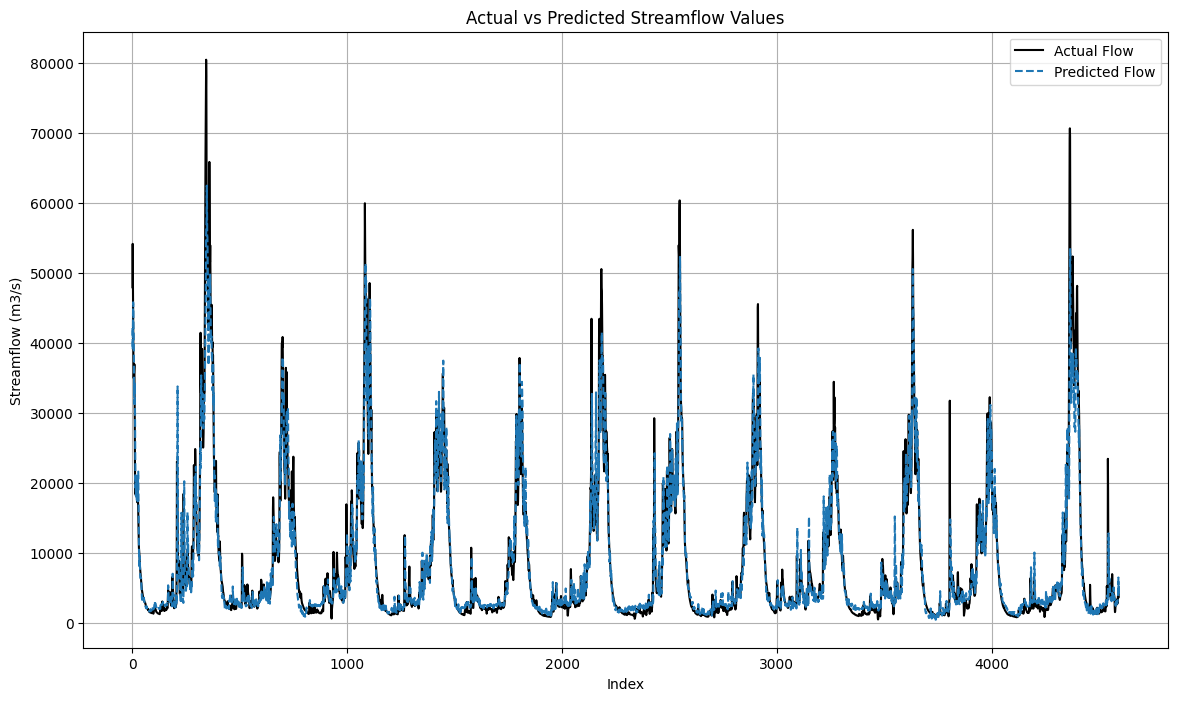

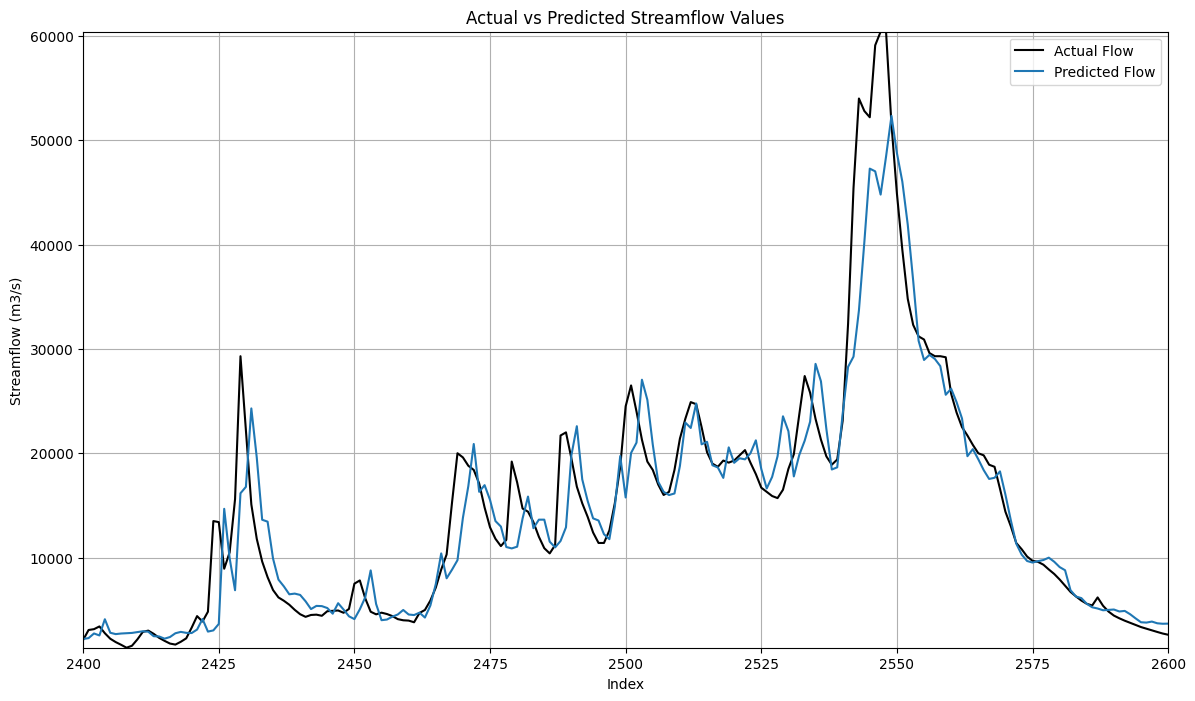

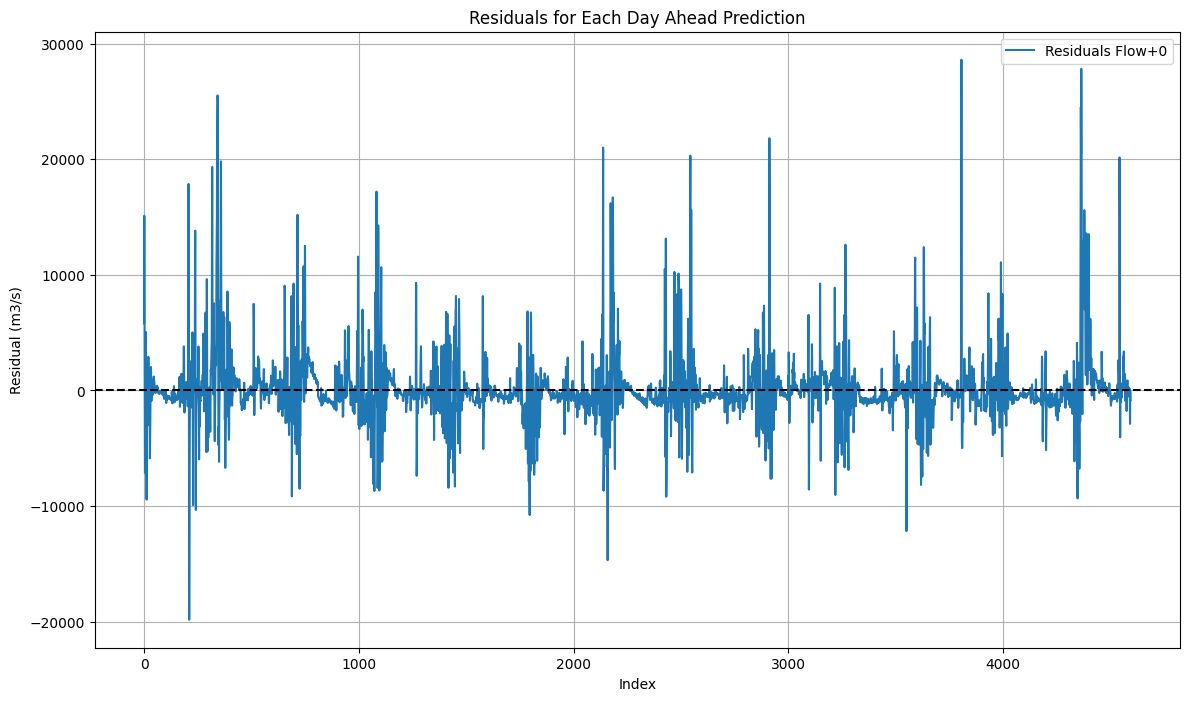

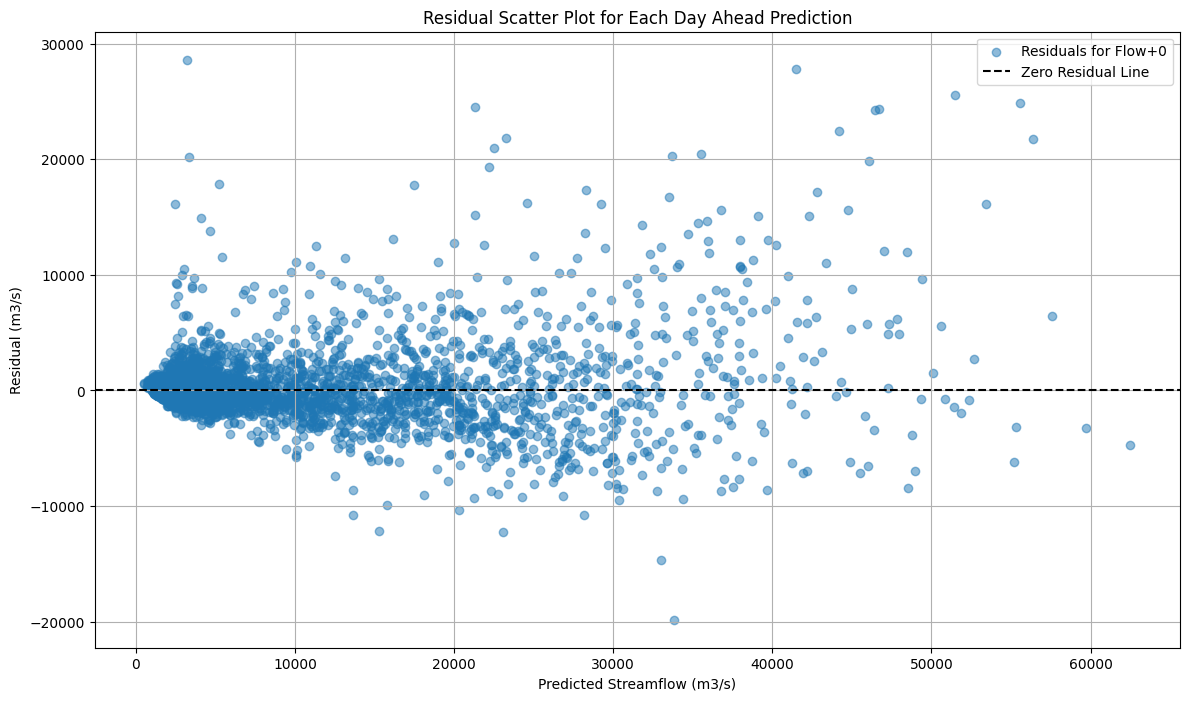

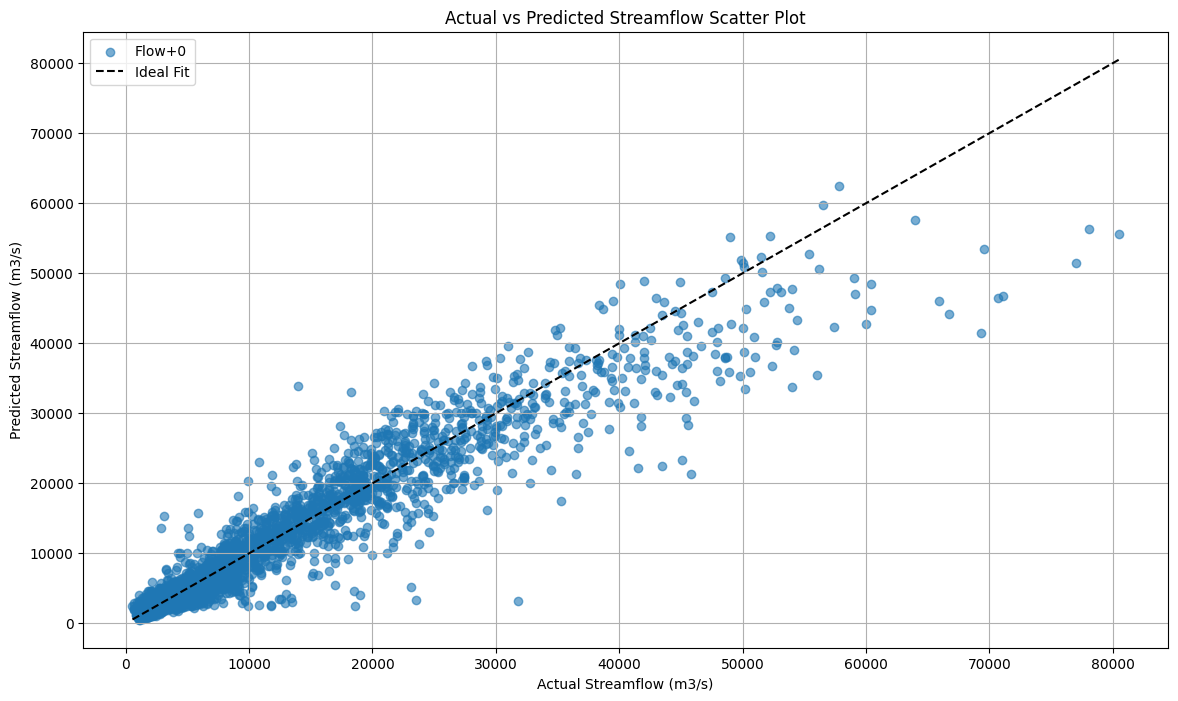

In [816]:
visualization(y_pred, y_test, 2400, 2600)

In [803]:
new_df = loadData('Data/Idaho/05131500_streamflow_qc.txt', 'Data/Idaho/05131500_lump_maurer_forcing_leap.txt')

rolling_horizons = [3, 7, 14]

for horizon in rolling_horizons:
    for col in ['prcp(mm/day)', 'srad(W/m2)', 'tmax(C)', 'Flow0', 'tmin(C)', 'vp(Pa)']:
        new_df = compute_rolling(new_df, horizon, col)

new_df = new_df.fillna(0)

for col in ['prcp(mm/day)', 'srad(W/m2)', 'tmax(C)', 'Flow0', 'tmin(C)', 'vp(Pa)']:
    new_df[f'month_avg_{col}'] = new_df[col].groupby(new_df.index.month, group_keys=False).apply(expand_mean)
    new_df[f'day_avg_{col}'] = new_df[col].groupby(new_df.index.day_of_year, group_keys=False).apply(expand_mean)


C:\Users\Abdullah Usmani\AppData\Local\Temp\ipykernel_11068\2899373820.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df1 = pd.read_csv(f'{flow}', delim_whitespace=True, header=None)
C:\Users\Abdullah Usmani\AppData\Local\Temp\ipykernel_11068\2899373820.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df2 = pd.read_csv(f'{meta}', skiprows=3, delim_whitespace=True)


In [804]:
# List of features to drop based on importance scores
features_to_drop = [
    'Year', 'SYM_A', 'SYM_A:e', 'rolling_3_prcp(mm/day)', 'rolling_3_srad(W/m2)_pct',
    'rolling_3_tmax(C)_pct', 'rolling_3_tmin(C)_pct', 'rolling_7_prcp(mm/day)',
    'rolling_7_prcp(mm/day)_pct', 'rolling_7_tmax(C)', 'rolling_7_tmax(C)_pct',
    'rolling_7_tmin(C)_pct', 'rolling_7_vp(Pa)', 'rolling_14_srad(W/m2)_pct',
    'rolling_14_tmax(C)', 'rolling_14_tmin(C)', 'month_avg_vp(Pa)', 'day_avg_vp(Pa)',
    'Mnth', 'Day', 'rolling_14_prcp(mm/day)', 'month_avg_tmax(C)', 'swe(mm)', 'SYM_nan', 'tmax(C)', 'tmin(C)', 
    'rolling_3_tmax(C)', 'rolling_14_srad(W/m2)', 
    'rolling_14_tmax(C)_pct', 'rolling_14_tmin(C)_pct', 
    'month_avg_prcp(mm/day)', 'month_avg_srad(W/m2)'
]

# Drop the features from the DataFrame
new_df = new_df.drop(columns=features_to_drop)

Y_new = new_df['Flow+3']  # Target variable
X_new = new_df.drop(['Flow0', 'Flow+1', 'Flow+2', 'Flow+3'], axis=1)  # Features
X_new = X_new.columns

predictions_new, scaler_X, scaler_Y = backtest(new_df, model, X_new, Y_new)

# X_new = scaler_X.transform(X_new)
# # Y_new = scaler_Y.transform(Y_new)

# # Step 3: Make predictions
# predictions_new = model.predict(X_new)

# # If needed, inverse transform predictions_new
# predictions_new = scaler_Y.inverse_transform(predictions_new)

# # Step 4: Create a DataFrame to store the results
# results = pd.DataFrame(predictions_new, columns=['Predictions'], index=new_df.index)

# # Optional: Add the actual target values if available
# results['Actual'] = Y_new

Epoch 1/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2708 - mean_squared_error: 0.2500 - val_loss: 0.1939 - val_mean_squared_error: 0.1666
Epoch 2/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2435 - mean_squared_error: 0.2166 - val_loss: 0.2036 - val_mean_squared_error: 0.1763
Epoch 3/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2367 - mean_squared_error: 0.2089 - val_loss: 0.2049 - val_mean_squared_error: 0.1770
Epoch 4/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2207 - mean_squared_error: 0.1928 - val_loss: 0.2130 - val_mean_squared_error: 0.1850
Epoch 5/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2134 - mean_squared_error: 0.1856 - val_loss: 0.2455 - val_mean_squared_error: 0.2158
Epoch 6/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2112 - mean_squared_error: 0.1821 - val_loss: 0.2017 - val_mean_squared_error: 0.1716
Epoch 7/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2094 - mean_squared_error: 0.1797 - val_loss: 0.19

In [805]:
y_pred_new1 = predictions_new["prediction"]
y_test_new1 = predictions_new["actual"]
y_pred_new1 = np.maximum(y_pred_new1, 0)  # Ensure no negative predictions
y_pred_new1 = np.minimum(y_pred_new1, np.max(y_test_new1) * 1.10)  # Cap predictions at 10% above max value of y_test


MAE: 276.04 m3/s
MSE: 429750.52 m3/s
RMSE: 655.55 m3/s
MAPE: 0.6%
Accuracy: 99.398%
R2: 0.8352


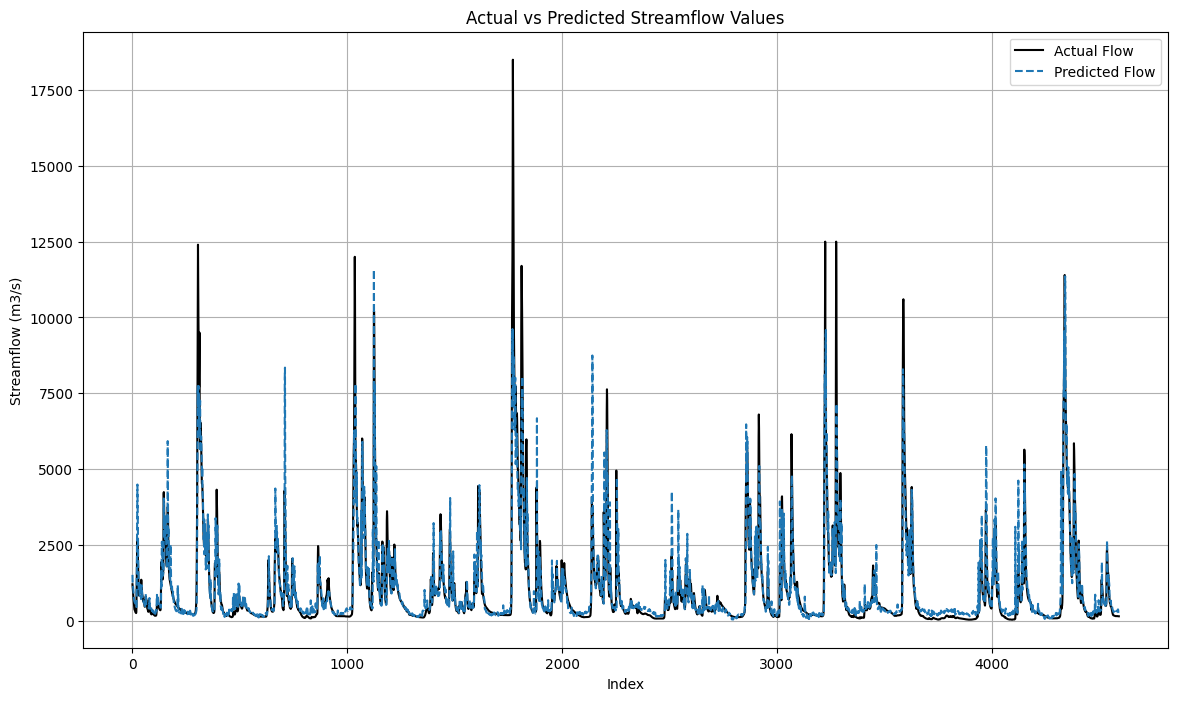

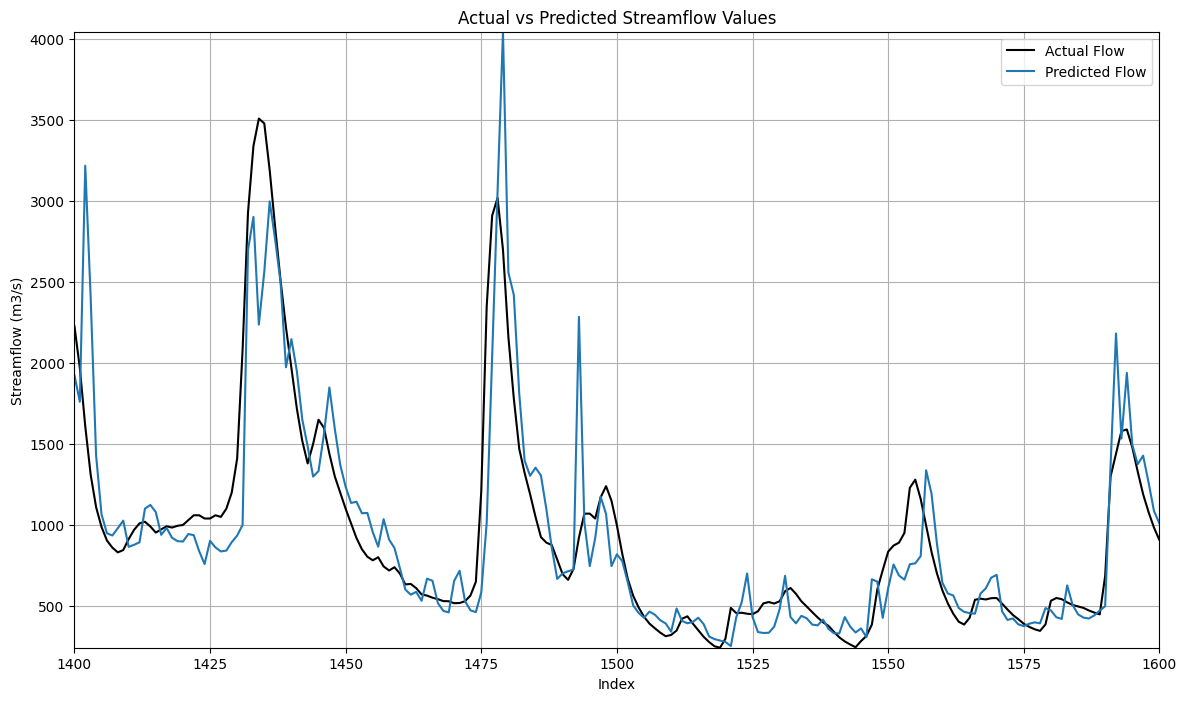

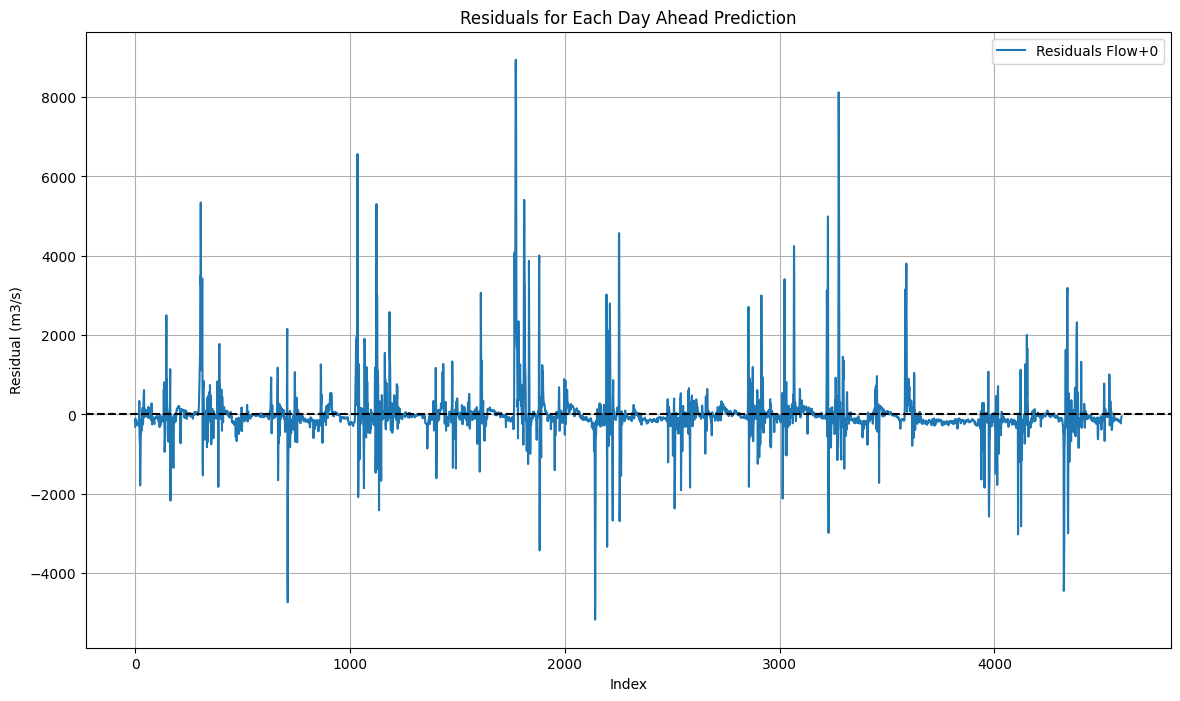

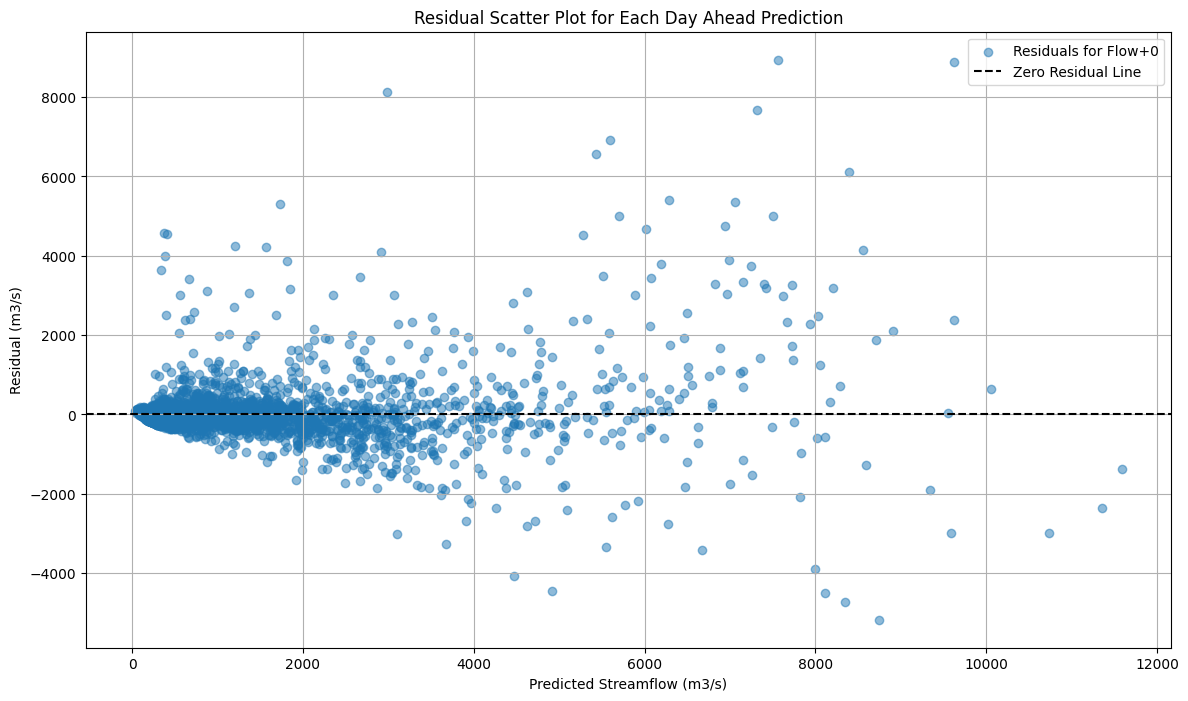

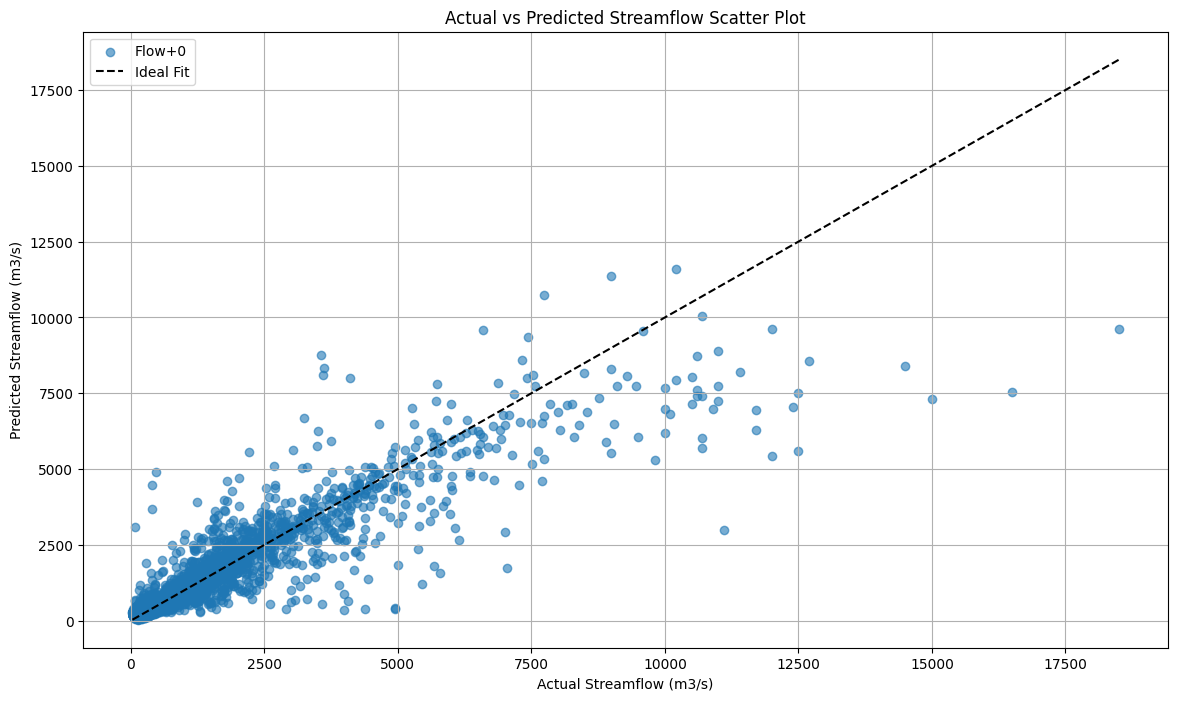

In [817]:

visualization(y_pred_new1, y_test_new1, 1400, 1600)

In [807]:
new_df = loadData('Data/Idaho/04045500_streamflow_qc.txt', 'Data/Idaho/04045500_lump_maurer_forcing_leap.txt')
new_df = new_df.drop(['SYM_M'], axis=1)
rolling_horizons = [3, 7, 14]

for horizon in rolling_horizons:
    for col in ['prcp(mm/day)', 'srad(W/m2)', 'tmax(C)', 'Flow0', 'tmin(C)', 'vp(Pa)']:
        new_df = compute_rolling(new_df, horizon, col)

new_df = new_df.fillna(0)

for col in ['prcp(mm/day)', 'srad(W/m2)', 'tmax(C)', 'Flow0', 'tmin(C)', 'vp(Pa)']:
    new_df[f'month_avg_{col}'] = new_df[col].groupby(new_df.index.month, group_keys=False).apply(expand_mean)
    new_df[f'day_avg_{col}'] = new_df[col].groupby(new_df.index.day_of_year, group_keys=False).apply(expand_mean)

# List of features to drop based on importance scores
features_to_drop = [
    'Year', 'SYM_A', 'SYM_A:e', 'rolling_3_prcp(mm/day)', 'rolling_3_srad(W/m2)_pct',
    'rolling_3_tmax(C)_pct', 'rolling_3_tmin(C)_pct', 'rolling_7_prcp(mm/day)',
    'rolling_7_prcp(mm/day)_pct', 'rolling_7_tmax(C)', 'rolling_7_tmax(C)_pct',
    'rolling_7_tmin(C)_pct', 'rolling_7_vp(Pa)', 'rolling_14_srad(W/m2)_pct',
    'rolling_14_tmax(C)', 'rolling_14_tmin(C)', 'month_avg_vp(Pa)', 'day_avg_vp(Pa)',
    'Mnth', 'Day', 'rolling_14_prcp(mm/day)', 'month_avg_tmax(C)', 'swe(mm)', 'SYM_nan', 'tmax(C)', 'tmin(C)', 
    'rolling_3_tmax(C)', 'rolling_14_srad(W/m2)', 
    'rolling_14_tmax(C)_pct', 'rolling_14_tmin(C)_pct', 
    'month_avg_prcp(mm/day)', 'month_avg_srad(W/m2)'
]

# Drop the features from the DataFrame
new_df = new_df.drop(columns=features_to_drop)

Y_new = new_df[['Flow+3']]  # Target variable
X_new = new_df.drop(['Flow0', 'Flow+1', 'Flow+2', 'Flow+3'], axis=1)  # Features
# X_new = X_new.columns

# predictions_new, scaler_X, scaler_Y = backtest(new_df, model, X_new, Y_new)

X_new = scaler_X.transform(X_new)
# Y_new = scaler_Y.transform(Y_new)

# Step 3: Make predictions
predictions_new = model.predict(X_new)

# If needed, inverse transform predictions_new
predictions_new = scaler_Y.inverse_transform(predictions_new)

# Step 4: Create a DataFrame to store the results
results = pd.DataFrame(predictions_new, columns=['Predictions'], index=new_df.index)

# Optional: Add the actual target values if available
results['Actual'] = Y_new

y_pred_new2 = results["Predictions"]
y_test_new2 = results["Actual"]

C:\Users\Abdullah Usmani\AppData\Local\Temp\ipykernel_11068\2899373820.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df1 = pd.read_csv(f'{flow}', delim_whitespace=True, header=None)
C:\Users\Abdullah Usmani\AppData\Local\Temp\ipykernel_11068\2899373820.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df2 = pd.read_csv(f'{meta}', skiprows=3, delim_whitespace=True)


In [809]:
# y_pred_new2 = predictions_new["prediction"]
# y_test_new2 = predictions_new["actual"]
y_pred_new2 = np.maximum(y_pred_new2, 0)  # Ensure no negative predictions
y_pred_new2 = np.minimum(y_pred_new2, np.max(y_test_new2) * 1.10)  # Cap predictions at 10% above max value of y_test


MAE: 175.63 m3/s
MSE: 119500.15 m3/s
RMSE: 345.69 m3/s
MAPE: 0.21%
Accuracy: 99.786%
R2: 0.8316


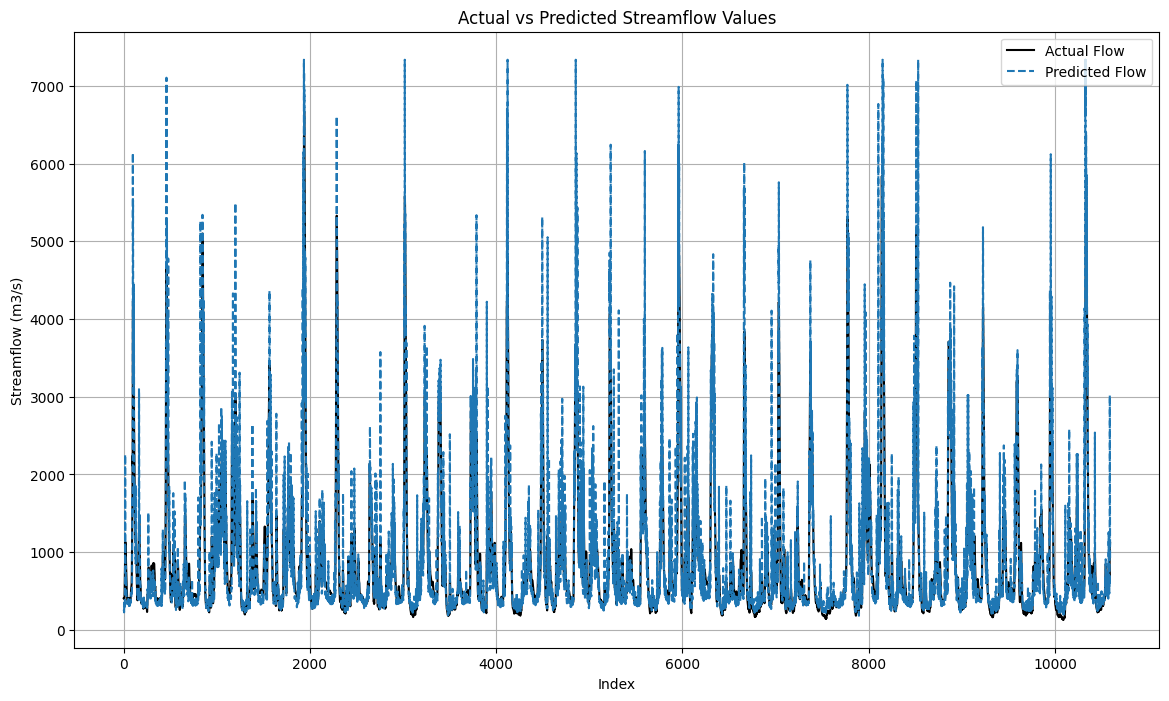

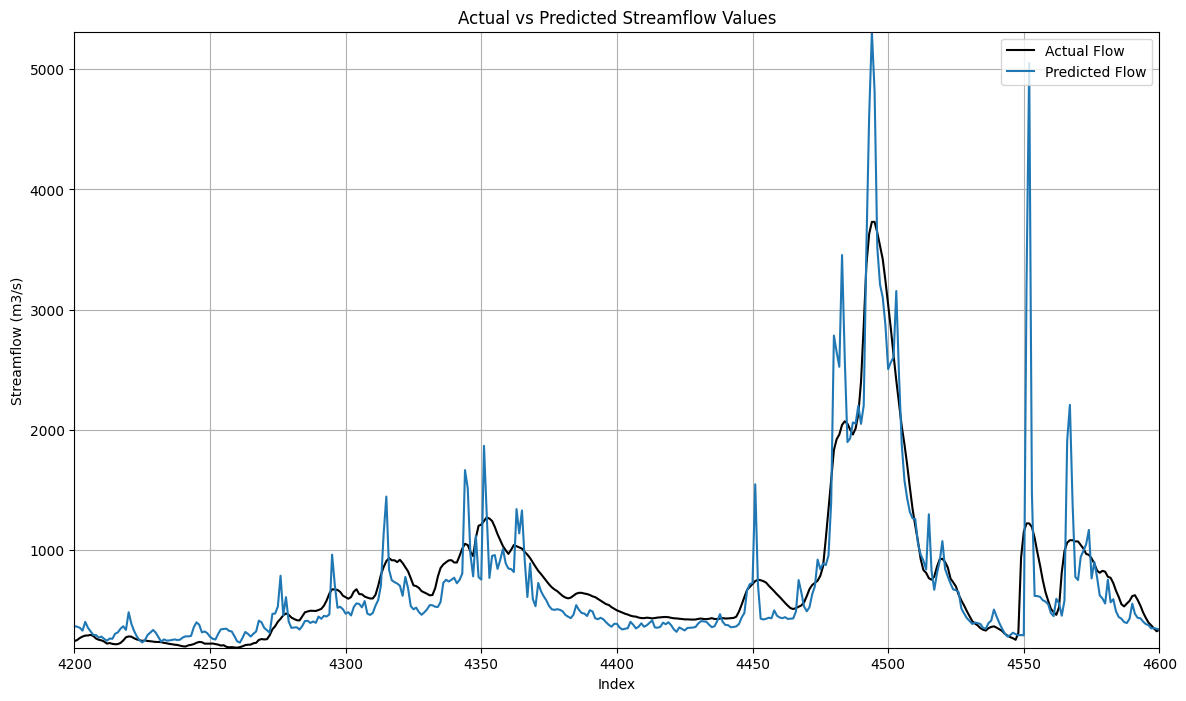

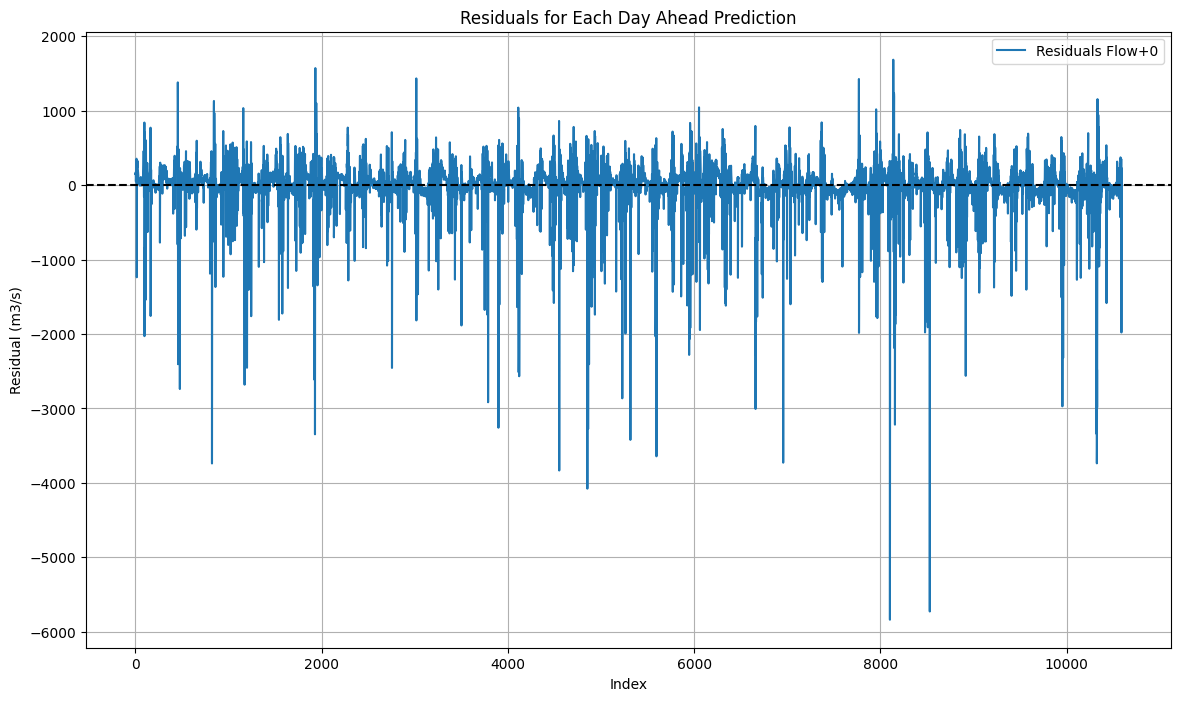

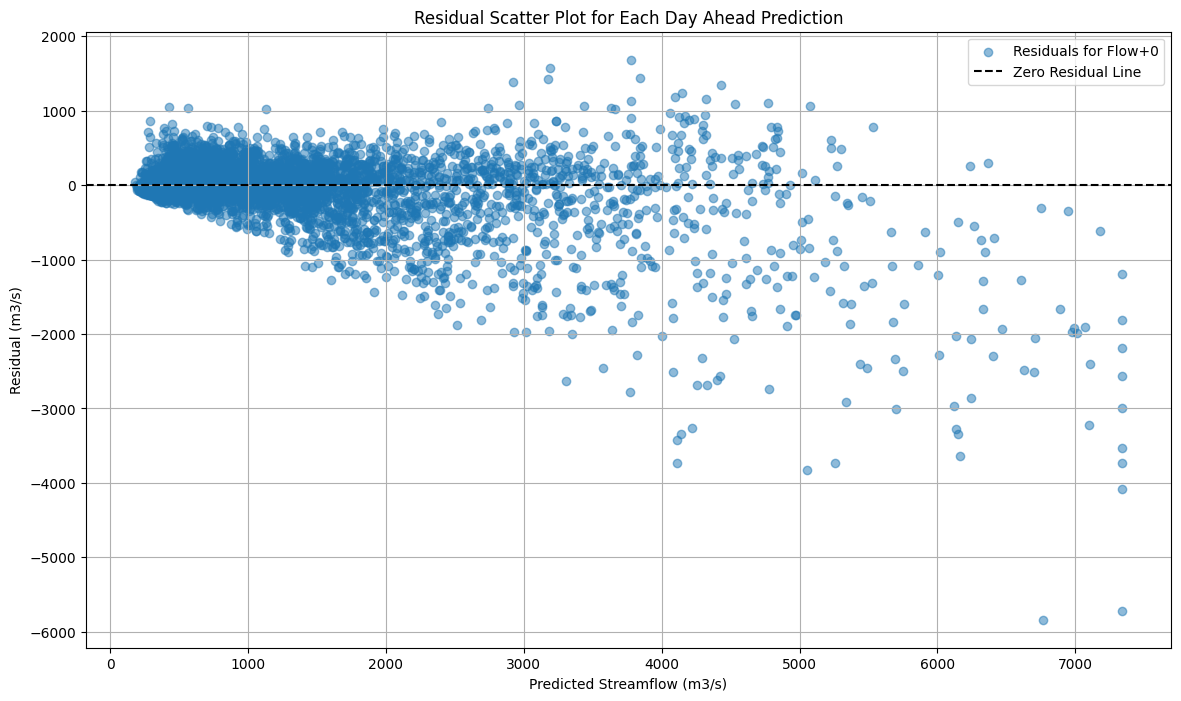

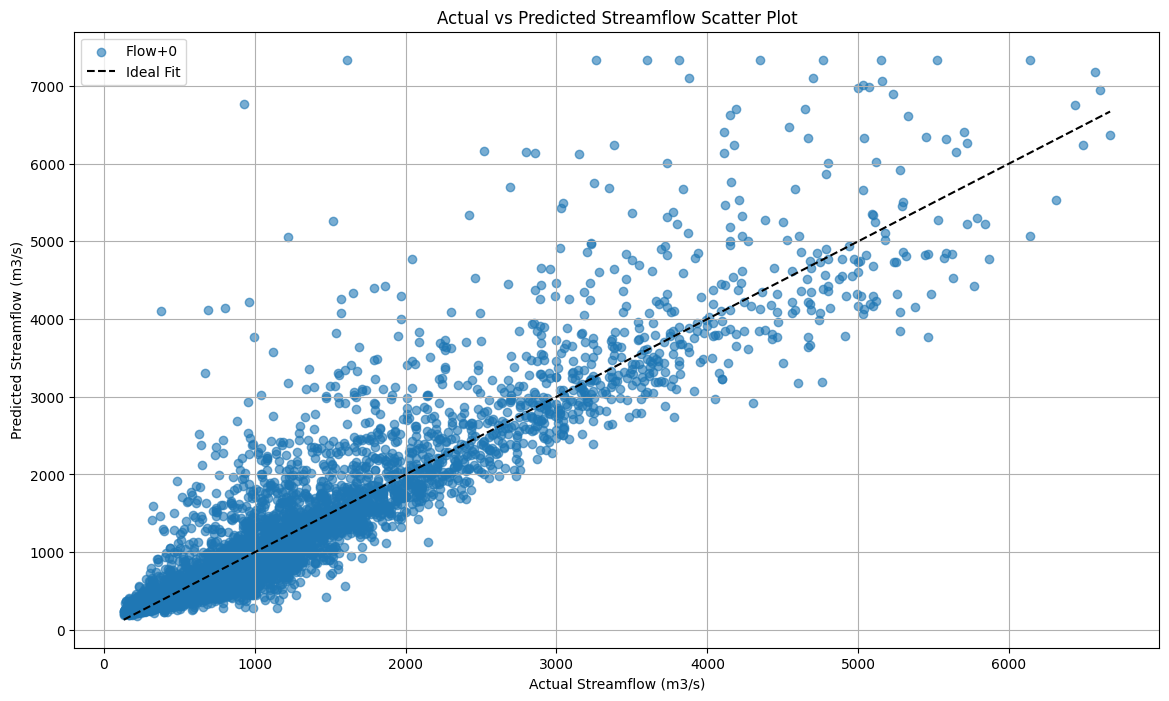

In [818]:

visualization(y_pred_new2, y_test_new2, 4200, 4600)

In [ ]:
forecast_steps = 30  # Number of days to forecast ahead

# Placeholder for predictions
predictions = []

# Initial input sequence (last known data)
current_sequence = new_df[-input_sequence_length:]  # Replace `input_sequence_length` with your actual length

for _ in range(forecast_steps):
    # Predict the next value
    next_pred = model.predict(current_sequence.reshape(1, -1))[0, 0]  # Adjust based on your model output shape
    predictions.append(next_pred)
    
    # Update the input sequence (shift and add new prediction)
    current_sequence = np.roll(current_sequence, -1)
    current_sequence[-1] = next_pred

# Convert predictions to array
predictions = np.array(predictions)

# Visualization
plt.figure(figsize=(14, 8))
plt.plot(range(len(history)), history, label='Historical Data')
plt.plot(range(len(history), len(history) + forecast_steps), predictions, label='Forecasted Data', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Forecasting 1 Month Ahead')
plt.legend()
plt.grid(True)
plt.show()